#### Introduction to generative adversarial networks
Generative adversarial networks (GANs), introduced in 2014 by Goodfellow et al.,7 are an alternative to VAEs for learning latent spaces of images. They enable the generation of fairly realistic synthetic images by forcing the generated images to be statistically almost indistinguishable from real ones. <br>
An intuitive way to understand GANs is to imagine a forger trying to create a fake Picasso painting. At first, the forger is pretty bad at the task. He mixes some of his fakes with authentic Picassos and shows them all to an art dealer. The art dealer makes an authenticity assessment for each painting and gives the forger feedback about what makes a Picasso look like a Picasso. The forger goes back to his studio to prepare some new fakes. As time goes on, the forger becomes increasingly competent at imitating the style of Picasso, and the art dealer becomes increasingly expert at spotting fakes. <br>
In the end, they have on their hands some excellent fake Picassos. <br>
That’s what a GAN is: a forger network and an expert network, each being trained to best the other. As such, a GAN is made of two parts:
- **Generator network**—Takes as input a random vector (a random point in the latent space), and decodes it into a synthetic image
- **Discriminator network (or adversary)**—Takes as input an image (real or synthetic), and predicts whether the image came from the training set or was created by the generator network

The generator network is trained to be able to fool the discriminator network, and thus it evolves toward generating increasingly realistic images as training goes on: artificial images that look indistinguishable from real ones, to the extent that it’s impossible for the discriminator network to tell the two apart (see figure 12.19). Meanwhile, the discriminator is constantly adapting to the gradually improving capabilities of the generator, setting a high bar of realism for the generated images. Once training is over, the generator is capable of turning any point in its input space into a believable image. Unlike VAEs, this latent space has fewer explicit guarantees of meaningful structure; in particular, it isn’t continuous.

![](./images/12.19.png)

Remarkably, a GAN is a system where the optimization minimum isn’t fixed, unlike in any other training setup you’ve encountered in this book. Normally, gradient descent consists of rolling down hills in a static loss landscape. But with a GAN, every step taken down the hill changes the entire landscape a little. It’s a dynamic system where the optimization process is seeking not a minimum, but an equilibrium between two forces. For this reason, GANs are notoriously difficult to train—getting a GAN to work requires lots of careful tuning of the model architecture and training parameters.

##### A schematic GAN implementation
In this section, we’ll explain how to implement a GAN in Keras in its barest form. GANs are advanced, so diving deeply into the technical details of architectures like that of the StyleGAN2 that generated the images in figure 12.20 would be out of scope for this book. The specific implementation we’ll use in this demonstration is a deep convolutional GAN (DCGAN): a very basic GAN where the generator and discriminator are deep convnets.

![](./images/12.20.png)

We’ll train our GAN on images from the Large-scale CelebFaces Attributes dataset (known as CelebA), a dataset of 200,000 faces of celebrities (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) To speed up training, we’ll resize the images to 64 × 64, so we’ll be learning to generate 64 × 64 images of human faces. <br>
Schematically, the GAN looks like this:
- A generator network maps vectors of shape (latent_dim,) to images of shape (64, 64, 3).
- A discriminator network maps images of shape (64, 64, 3) to a binary score estimating the probability that the image is real.
- A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus, this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.
- We train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as we train any regular image-classification model.
- To train the generator, we use the gradients of the generator’s weights with regard to the loss of the gan model. This means that at every step, we move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, we train the generator to fool the discriminator.

##### A bag of tricks
The process of training GANs and tuning GAN implementations is notoriously difficult. There are a number of known tricks you should keep in mind. Like most things in deep learning, it’s more alchemy than science: these tricks are heuristics, not theorybacked guidelines. They’re supported by a level of intuitive understanding of the phenomenon at hand, and they’re known to work well empirically, although not necessarily in every context. <br>
Here are a few of the tricks used in the implementation of the GAN generator and discriminator in this section. It isn’t an exhaustive list of GAN-related tips; you’ll find many more across the GAN literature:
- We use strides instead of pooling for downsampling feature maps in the discriminator, just like we did in our VAE encoder.
- We sample points from the latent space using a normal distribution (Gaussian distribution), not a uniform distribution.
- Stochasticity is good for inducing robustness. Because GAN training results in a dynamic equilibrium, GANs are likely to get stuck in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness by adding random noise to the labels for the discriminator.
- Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. Two things can induce gradient sparsity: max pooling operations and relu activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a LeakyReLU layer instead of a relu activation. It’s similar to relu, but it relaxes sparsity constraints by allowing small negative activation values.
- In generated images, it’s common to see checkerboard artifacts caused by unequal coverage of the pixel space in the generator (see figure 12.21). To fix this, we use a kernel size that’s divisible by the stride size whenever we use a strided Conv2DTranspose or Conv2D in both the generator and the discriminator.

![](./images/12.21.png)

##### Getting our hands on the CelebA dataset
You can download the dataset manually from the website: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html. If you’re using Colab, you can run the following to download the data from Google Drive and uncompress it.

##### Getting the CelebA data

In [ ]:
!mkdir celeba_gan # Create a working directory.
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip # Download the compressed data using gdown (available by default in Colab; install it otherwise).
!unzip -qq celeba_gan/data.zip -d celeba_gan # Uncompress the data.

Once you’ve got the uncompressed images in a directory, you can use **image_dataset_from_directory** to turn it into a dataset. Since we just need the images—there are no labels—we’ll specify label_mode=None.

##### Creating a dataset from a directory of images

In [11]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None, # Only the images will be returned—no labels.
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True) # We will resize the images to 64 × 64 by using a smart combination of cropping and resizing to preserve aspect ratio. 
    # We don’t want face proportions to get distorted!

Found 202599 files belonging to 1 classes.


Finally, let’s rescale the images to the [0-1] range.

##### Rescaling the images

In [12]:
dataset = dataset.map(lambda x: x / 255.)

You can use the following code to display a sample image.

##### Displaying the first image

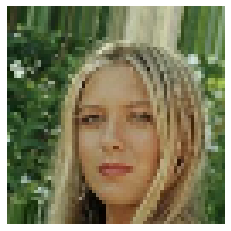

In [13]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

##### The discriminator
First, we’ll develop a **discriminator** model that takes as input a candidate image(real or synthetic) and classifies it into one of two classes: “generated image” or “real image that comes from the training set.” One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use **dropout** in the discriminator, so that’s what we will do here.

##### The GAN discriminator network

In [14]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2), # One dropout layer: an important trick!
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

Here’s the discriminator model summary:

In [15]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

##### The generator
Next, let’s develop a generator model that turns a vector (from the latent space—during training it will be sampled at random) into a candidate image.

##### GAN generator network

In [16]:
latent_dim = 128 # The latent space will be made of 128-dimensional vectors.

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128), # Produce the same number of coefficients we had at the level of the Flatten layer in the encoder.
        layers.Reshape((8, 8, 128)),# Revert the Flatten layer of the encoder.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"), # Revert the Conv2D layers of the encoder.
        layers.LeakyReLU(alpha=0.2), # We use LeakyReLU as our activation.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"), # The output ends up with shape(28, 28, 1).
    ],
    name="generator",
)

This is the generator model summary:

In [17]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

##### The adversarial network
Finally, we’ll set up the GAN, which chains the generator and the discriminator. When trained, this model will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent-space points into a classification decision—“fake” or “real”—and it’s meant to be trained with labels that are always “these are real images.” So training gan will update the weights of generator in a way that makes discriminator more likely to predict “real” when looking at fake images. <br>
To recapitulate, this is what the training loop looks like schematically. For each epoch, you do the following:
1. Draw random points in the latent space (random noise).
2. Generate images with generator using this random noise.
3. Mix the generated images with real ones.
4. Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).
5. Draw new random points in the latent space.
6. Train generator using these random vectors, with targets that all say “these are real images.” This updates the weights of the generator to move them toward getting the discriminator to predict “these are real images” for generated images: this trains the generator to fool the discriminator.

Let’s implement it. Like in our VAE example, we’ll use a Model subclass with a custom train_step(). Note that we’ll use two optimizers (one for the generator and one for the discriminator), so we will also override compile() to allow for passing two optimizers.

##### The GAN Model

In [18]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Sets up metrics to track the two losses over each training epoch
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Samples random points in the latent space      
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Decodes them to fake images
        generated_images = self.generator(random_latent_vectors)
        # Combines them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assembles labels, discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Adds random noise to the labels—an important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Trains the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Samples random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        # Assembles labels that say “these are all real images” (it’s a lie!)
        misleading_labels = tf.zeros((batch_size, 1))

        # Trains the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

Before we start training, let’s also set up a callback to monitor our results: it will use the generator to create and save a number of fake images at the end of each epoch.

##### A callback that samples generated images during training

In [19]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finally, we can start training.

##### Compiling and training the GAN

In [ ]:
epochs = 100 # You’ll start getting interesting results after epoch 20.

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

When training, you may see the adversarial loss begin to increase considerably, while the discriminative loss tends to zero—the discriminator may end up dominating the generator. If that’s the case, try reducing the discriminator learning rate, and increase the dropout rate of the discriminator. <br>
Figure 12.22 shows what our GAN is capable of generating after 30 epochs of training.

##### Wrapping up
- A GAN consists of a generator network coupled with a discriminator network. The discriminator is trained to differentiate between the output of the generator and real images from a training dataset, and the generator is trained to fool the discriminator. Remarkably, the generator never sees images from the training set directly; the information it has about the data comes from the discriminator.
- GANs are difficult to train, because training a GAN is a dynamic process rather than a simple gradient descent process with a fixed loss landscape. Getting a GAN to train correctly requires using a number of heuristic tricks, as well as extensive tuning.
- GANs can potentially produce highly realistic images. But unlike VAEs, the latent space they learn doesn’t have a neat continuous structure and thus may not be suited for certain practical applications, such as image editing via latent space concept vectors.

These few techniques cover only the basics of this fast-expanding field. There’s a lot more to discover out there—generative deep learning is deserving of an entire book of its own.

#### Summary
- You can use a sequence-to-sequence model to generate sequence data, one step at a time. This is applicable to text generation, but also to note-by-note music generation or any other type of timeseries data.
- DeepDream works by maximizing convnet layer activations through gradient ascent in input space.
- In the style-transfer algorithm, a content image and a style image are combined together via gradient descent to produce an image with the high-level features of the content image and the local characteristics of the style image.
- VAEs and GANs are models that learn a latent space of images and can then dream up entirely new images by sampling from the latent space. Concept vectors in the latent space can even be used for image editing.